In [1]:
import ast
import gc
import glob
import os

import cv2
import joblib
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pretrainedmodels
import skimage
import torch
import torchvision
from albumentations import (CenterCrop, Compose, HorizontalFlip, Normalize,
                            PadIfNeeded, RandomCrop, RandomScale, Resize,
                            VerticalFlip)
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import models
from tqdm import tqdm
from PIL import Image, ImageDraw


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
    
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)


def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

In [3]:
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
device = 'cuda:1'


torch.backends.cudnn.benchmark = True
debug = True
grayscale = False

df_num_rows = 25000
valid_size = 0.2

line_width = 6
base_size = 320
constant_size = 96
image_size = (constant_size, constant_size)

num_epochs = 120
batch_size = 32

In [5]:
dfs_all = sorted(glob.glob('../../../input/train_chunks_full/*.csv'))
if debug:
    dfs_all = dfs_all[:10]
    df_num_rows = 100
    
print('all DFS: {}'.format(len(dfs_all)))

dfs_all = np.random.permutation(dfs_all)
dfs_train = dfs_all[:-2]
dfs_valid = dfs_all[-2:]

print('DFs train: {}'.format(len(dfs_train)))
print('DFs valid: {}'.format(len(dfs_valid)))

df1 = pd.read_csv(dfs_train[0])

dfs_train

all DFS: 10
DFs train: 8
DFs valid: 2


array(['../../../input/train_chunks_full/train_k10_shuffled.csv',
       '../../../input/train_chunks_full/train_k16_shuffled.csv',
       '../../../input/train_chunks_full/train_k17_shuffled.csv',
       '../../../input/train_chunks_full/train_k11_shuffled.csv',
       '../../../input/train_chunks_full/train_k0_shuffled.csv',
       '../../../input/train_chunks_full/train_k18_shuffled.csv',
       '../../../input/train_chunks_full/train_k13_shuffled.csv',
       '../../../input/train_chunks_full/train_k12_shuffled.csv'],
      dtype='<U55')

In [6]:
r_ind = np.random.randint(0, len(df1))

raw_strokes = df1.drawing[r_ind]
raw_strokes = ast.literal_eval(raw_strokes)

line_width = 6
base_size = 256
center = True

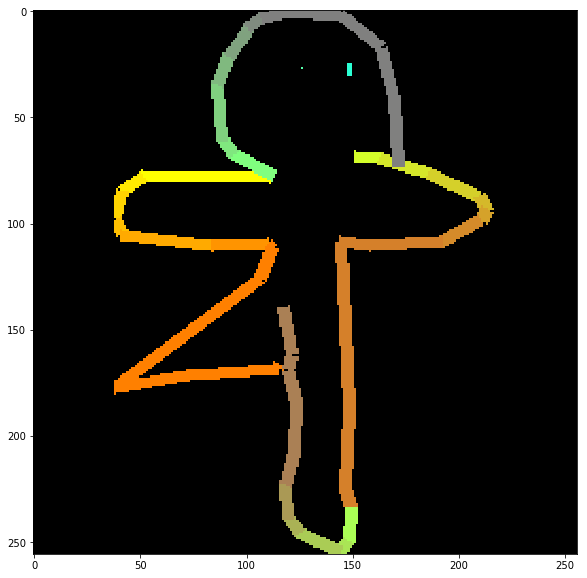

In [7]:
image = Image.new('RGB', (base_size, base_size))
draw = ImageDraw.Draw(image)
for t, stroke in enumerate(raw_strokes):
    blue = int(t / len(raw_strokes) * 255.0)
    red = 255 - blue
    for i in range(len(stroke[0]) - 1):
        green = max(
            int(255.0 - i / (len(stroke[0]) - 1) * 255.0), 128)
        draw.line(
            (stroke[0][i], stroke[1][i],
             stroke[0][i + 1], stroke[1][i + 1]),
            fill=(red, green, blue), width=line_width)
        
        
image = np.asarray(image)

if center:
    nzero_vals = np.max(image, axis=0) > 0
    nzero_ind = np.where(nzero_vals)[0]
    begin, end = nzero_ind[0], nzero_ind[-1]
    tx = (base_size - end + begin - 1) // 2
    M = np.float32([[1, 0, tx], [0, 1, 0]])
    image = cv2.warpAffine(image, M, image.shape[:2])
    
    nzero_vals = np.max(image, axis=1) > 0
    nzero_ind = np.where(nzero_vals)[0]
    begin, end = nzero_ind[0], nzero_ind[-1]
    tx = (base_size - end + begin - 1) // 2
    M = np.float32([[1, 0, 0], [0, 1, tx]])
    image = cv2.warpAffine(image, M, image.shape[:2])
    
plt.imshow(image)

In [9]:
h, w = image_size[0], image_size[1]


dataset_parameters = {
    'base_size': base_size,
    'line_width': line_width,
    'df_num_rows': df_num_rows,
    'divide': True,
    'color': True,
}

valid_dataset_parameters = {
    'base_size': base_size,
    'line_width': line_width,
    'df_num_rows': 30000,
    'divide': True,
    'color': True,
}

def train_transform(p=1):
    return Compose([
        # VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        # RandomScale(scale_limit=0.3, p=0.5),
        Resize(h, w),
        # RandomCrop(h, w),
        # PadIfNeeded(h, w, 0),
        # Normalize(p=0, max_pixel_value=1.0)
    ], p=p)


def valid_transform(p=1):
    return Compose([
        Resize(h, w),
        # CenterCrop(h, w),
        # Normalize(p=0, max_pixel_value=1.0)
    ], p=p)

In [10]:
from kaggledoodlewr.data.torch_dataset_doodle import DoodleDataset


train_dataset = DoodleDataset(
    dfs_train[0],
    **dataset_parameters,
    transform=train_transform())

valid_dataset = DoodleDataset(
    dfs_valid[0],
    **valid_dataset_parameters,
    transform=valid_transform())


train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True)

valid_loader = data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=3,
    pin_memory=True)

DF shape: (100, 3)
DF shape: (30000, 3)


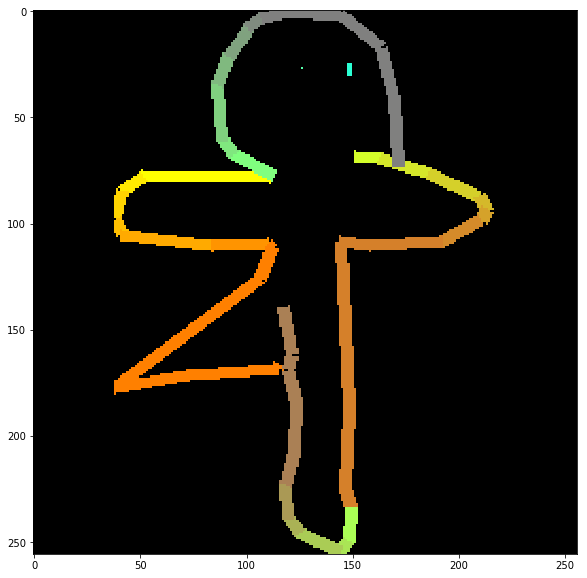

In [12]:
img = train_dataset.draw_pil(raw_strokes, center=True)
plt.imshow(img)

In [ ]:
from kaggledoodlewr.models import *


model_parameters = {
    'num_classes': 340,
    'pretrained': True,
    'num_channels': 3,
    'pooling_output_dim': 2,
    'model_name': 'se_resnext50_32x4d',
}

def get_model(params):
    model = SENet(params)
    # model = ResNet_(params)
    model.train()
    model.to(device)
    return model

In [ ]:
asd

In [ ]:
%%time


model = get_model(model_parameters)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_iter_print = 10000
n_iter_eval = 10000


losses_ = AverageMeter()
top1 = AverageMeter()
top5 = AverageMeter()
top_map3 = AverageMeter()


for e in range(num_epochs):

    train_loss = []
    n_iter = 0
    
    for image, target in tqdm(train_loader):
        
        image = image.to(device)
        y_pred = model(image)
        target = target.to(device)
        
        loss = loss_fn(y_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        n_iter += 1
        
        if n_iter % n_iter_print == 0:
            print('Step: {}'.format(n_iter))
        
        if n_iter % n_iter_eval == 0:
            
            print('Evaluate at step: {}'.format(n_iter))
            
            losses_ = AverageMeter()
            top1 = AverageMeter()
            top5 = AverageMeter()
            top_map3 = AverageMeter()
            for val_image, val_target in valid_loader:

                with torch.no_grad():
                    val_image = val_image.to(device)
                    y_pred = model(val_image)
                    val_target = val_target.to(device)

                    loss = loss_fn(y_pred, val_target)

                    acc1, acc5 = accuracy(y_pred, val_target, topk=(1, 5))
                    map3 = mapk(
                        np.expand_dims(val_target.cpu().detach().numpy(), axis=-1),
                        preds2catids(y_pred.cpu().detach().numpy()).values)

                    losses_.update(loss.item(), val_image.size(0))
                    top1.update(acc1[0], val_image.size(0))
                    top5.update(acc5[0], val_image.size(0))
                    top_map3.update(map3, val_image.size(0))
                    
            losses_.reset()
            top1.reset()
            top5.reset()
            top_map3.reset()
            
            print('Val acc@3: {:.3f}, MAP@3: {:.3f}'.format(top5.avg / 100, top_map3.avg))

    print("Epoch: %d, Train: %.3f, Val: %.3f" %
          (e, np.mean(train_loss), losses_.avg))

In [ ]:
img_ = image.cpu().detach().numpy()

In [ ]:
img_.shape

In [ ]:
plt.imshow(img_[3, 0])

In [ ]:
asd

### skimage:

- 10.7gb, 2.13it/s

### PIL

- 10.7gb, 2.04it/s
- 800 iters, 11.0gb
- 2500 iters, 11.3gb


4 threads:
- 10.5gb, 2.06it/s, 100 iters
- 11.2gb, 650 iters

In [ ]:
tr_imgs = []
tr_targets = []

for image, target in tqdm(train_loader):
    tr_imgs.append(image.cpu().detach().numpy())
    tr_targets.append(target.cpu().detach().numpy())
    
tr_imgs = np.vstack(tr_imgs)
tr_targets = np.concatenate(tr_targets)

print(tr_imgs.shape)

In [ ]:
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(16, 16))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow((-tr_imgs[i, 0, :, :] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
tr_targets